we are trying to modify the original 2D implementation of Swin in transformers and trying to make it work with 3D. 


Along the way we will try to understand a few concepts of Swin transformers. Specifically
- window attention
- shifted window attention 
- what a relative positional bias table is

> [Swin Paper](https://arxiv.org/pdf/2103.14030.pdf)

In [ ]:
#| default_exp swin3d

In [ ]:
#| export 
import math
import torch
import torch.nn as nn
import collections
from typing import Union, Optional, List, Tuple


from transformers.modeling_outputs import BackboneOutput
from transformers.modeling_utils import  PreTrainedModel
from transformers.models.swin.configuration_swin import SwinConfig
from transformers.pytorch_utils import meshgrid, find_pruneable_heads_and_indices
from transformers.models.swin.modeling_swin import SwinEncoderOutput, SwinModelOutput, SwinMaskedImageModelingOutput, SwinImageClassifierOutput, drop_path, SwinDropPath
from transformers.activations import ACT2FN
from transformers.utils.backbone_utils import BackboneMixin

## window partition

this take input features of shape `(batch_size, depth, height, width, num_channels)` and window_size in `(d, h, w)` as inputs and output windows of shape ``

In [ ]:
fe = torch.randn((1, 56, 56, 56, 128))
window_size = 7 #same in all direction

In [ ]:
batch_size, depth, height, width, num_channels = fe.shape
fe = fe.view(
        batch_size, depth // window_size, window_size, height // window_size, window_size, width // window_size, window_size, num_channels
    )
fe.shape

torch.Size([1, 8, 7, 8, 7, 8, 7, 128])

> we will have (8, 8, 8) windows and since batch size is 1, we will have total of 512 windows. 

In [ ]:
windows = fe.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous().view(-1, window_size, window_size, window_size, num_channels)
windows.shape

torch.Size([512, 7, 7, 7, 128])

In [ ]:
#| export 
# Copied from transformers.models.swin.modeling_swin.window_partition
def window_partition3d(input_feature, window_size: Union[int, List[int]]):
    """
    Partitions the given input into windows.
    """
    window_depth, window_height, window_width = window_size if isinstance(window_size, collections.abc.Iterable) else (window_size, window_size, window_size)
    batch_size, depth, height, width, num_channels = input_feature.shape
    input_feature = input_feature.view(
        batch_size, depth // window_depth, window_depth, height // window_height, window_height, width // window_width, window_width, num_channels
    )
    windows = input_feature.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous().view(-1, window_depth, window_height, window_width, num_channels)
    return windows

In [ ]:
fe = torch.randn((1, 56, 56, 56, 128))
window_size = 7 #same in all direction
window_partition3d(fe, window_size).shape

torch.Size([512, 7, 7, 7, 128])

## Window reverse 

we have to reverse the same process. usually the way this happens . take features -> apply windowing -> apply attention -> reverse windows. 

In [ ]:
num_channels = windows.shape[-1]
depth, height, width = 56, 56, 56
num_channels

128

In [ ]:
windows = windows.view(-1, depth // window_size, height // window_size, width // window_size, window_size, window_size, window_size, num_channels)
windows.shape

torch.Size([1, 8, 8, 8, 7, 7, 7, 128])

In [ ]:
windows = windows.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous().view(-1, depth, height, width, num_channels)
windows.shape

torch.Size([1, 56, 56, 56, 128])

In [ ]:
#| export 
# Copied from transformers.models.swin.modeling_swin.window_reverse
def window_reverse3d(windows, window_size, depth, height, width):
    """
    Merges windows to produce higher resolution features.
    """
    num_channels = windows.shape[-1]
    window_depth, window_height, window_width = window_size if isinstance(window_size, collections.abc.Iterable) else (window_size, window_size, window_size)
    windows = windows.view(-1, depth // window_depth, height // window_height, width // window_width, window_depth, window_height, window_width, num_channels)
    windows = windows.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous().view(-1, depth, height, width, num_channels)
    return windows

In [ ]:
fe = torch.randn((1, 56, 56, 56, 128))
window_size = 7 #same in all direction
windows = window_partition3d(fe, window_size)
num_channels = windows.shape[-1]
depth, height, width = 56, 56, 56
window_reverse3d(windows, window_size, depth, height, width).shape

torch.Size([1, 56, 56, 56, 128])

## SwinPatch Embeddings 

> First lets check How padding works for each axis. 

In [ ]:
x = torch.randn((1, 1, 91, 187, 189)) # the original image is (92, 192, 192)
batch_size, channels, depth, height, width = x.shape
patch_size = (2, 4, 4)

In [ ]:
width % patch_size[2] != 0

True

In [ ]:
pad_values = (0, 0, patch_size[1] - width % patch_size[1])
pad_values

(0, 0, 3)

In [ ]:
torch.nn.functional.pad(x, (0, 3)).shape

torch.Size([1, 1, 91, 187, 192])

> how padding works `p2d = (1, 1, 2, 2) # pad last dim by (1, 1) and 2nd to last by (2, 2)`

In [ ]:
torch.nn.functional.pad(x, (0, 0, 0, 3)).shape #> pad along H

torch.Size([1, 1, 91, 190, 189])

In [ ]:
torch.nn.functional.pad(x, (0, 0, 0, 0, 0, 1)).shape #> pad along D

torch.Size([1, 1, 92, 187, 189])

In [ ]:
class Swin3dConfig:
    num_channels = 1
    image_size = (96, 192, 192)
    patch_size = (2, 4, 4)
    embed_dim = 128
    use_absolute_embeddings=True
    hidden_dropout_prob=0.0
    qkv_bias=True

In [ ]:
#| export 
# Copied from transformers.models.swin.modeling_swin.SwinPatchEmbeddings
class Swin3dPatchEmbeddings(torch.nn.Module):
    """
    This class turns `pixel_values` of shape `(batch_size, num_channels, height, width)` into the initial
    `hidden_states` (patch embeddings) of shape `(batch_size, seq_length, hidden_size)` to be consumed by a
    Transformer.
    """

    def __init__(self, config):
        super().__init__()
        image_size, patch_size = config.image_size, config.patch_size
        num_channels, hidden_size = config.num_channels, config.embed_dim
        image_size = image_size if isinstance(image_size, collections.abc.Iterable) else (image_size, image_size, image_size)
        patch_size = patch_size if isinstance(patch_size, collections.abc.Iterable) else (patch_size, patch_size, patch_size)
        num_patches = (image_size[2] // patch_size[2])* (image_size[1] // patch_size[1]) * (image_size[0] // patch_size[0])
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_channels = num_channels
        self.num_patches = num_patches
        self.grid_size = (image_size[0] // patch_size[0], image_size[1] // patch_size[1], image_size[2] // patch_size[2])

        self.projection = torch.nn.Conv3d(num_channels, hidden_size, kernel_size=patch_size, stride=patch_size)

    def maybe_pad(self, pixel_values, depth, height, width):
        if width % self.patch_size[2] != 0:
            pad_values = (0, self.patch_size[1] - width % self.patch_size[1])
            pixel_values = nn.functional.pad(pixel_values, pad_values)
        if height % self.patch_size[1] != 0:
            pad_values = (0, 0, 0, self.patch_size[0] - height % self.patch_size[0])
            pixel_values = nn.functional.pad(pixel_values, pad_values)
        if depth % self.patch_size[0] !=0:
            pad_values = (0, 0, 0, 0, 0, self.patch_size[0] - depth % self.patch_size[0])
            pixel_values = nn.functional.pad(pixel_values, pad_values)
        return pixel_values

    def forward(self, pixel_values: Optional[torch.FloatTensor]) -> Tuple[torch.Tensor, Tuple[int]]:
        _, num_channels, depth, height, width = pixel_values.shape
        if num_channels != self.num_channels:
            raise ValueError(
                "Make sure that the channel dimension of the pixel values match with the one set in the configuration."
            )
        # pad the input to be divisible by self.patch_size, if needed
        pixel_values = self.maybe_pad(pixel_values, depth, height, width)
        embeddings = self.projection(pixel_values)
        _, _, depth, height, width = embeddings.shape
        output_dimensions = (depth, height, width)
        embeddings = embeddings.flatten(2).transpose(1, 2)
        return embeddings, output_dimensions

In [ ]:
cfg = Swin3dConfig()
pe = Swin3dPatchEmbeddings(cfg)
pe

Swin3dPatchEmbeddings(
  (projection): Conv3d(1, 128, kernel_size=(2, 4, 4), stride=(2, 4, 4))
)

In [ ]:
x = torch.randn((1, 1, 96, 192, 192))
x.shape

torch.Size([1, 1, 96, 192, 192])

In [ ]:
embeddings, od = pe(x)
embeddings.shape, od

(torch.Size([1, 110592, 128]), (48, 48, 48))

## SwinEmbeddings 

In [ ]:
#| export 
# Copied from transformers.models.swin.modeling_swin.SwinEmbeddings
class Swin3dEmbeddings(nn.Module):
    """
    Construct the patch and position embeddings. Optionally, also the mask token.
    """

    def __init__(self, config, use_mask_token=False):
        super().__init__()

        self.patch_embeddings = Swin3dPatchEmbeddings(config)
        num_patches = self.patch_embeddings.num_patches
        self.patch_grid = self.patch_embeddings.grid_size
        self.mask_token = nn.Parameter(torch.zeros(1, 1, config.embed_dim)) if use_mask_token else None

        if config.use_absolute_embeddings:
            self.position_embeddings = nn.Parameter(torch.zeros(1, num_patches + 1, config.embed_dim))
        else:
            self.position_embeddings = None

        self.norm = nn.LayerNorm(config.embed_dim)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(
        self, pixel_values: Optional[torch.FloatTensor], bool_masked_pos: Optional[torch.BoolTensor] = None
    ) -> Tuple[torch.Tensor]:
        embeddings, output_dimensions = self.patch_embeddings(pixel_values)
        embeddings = self.norm(embeddings)
        batch_size, seq_len, _ = embeddings.size()

        if bool_masked_pos is not None:
            mask_tokens = self.mask_token.expand(batch_size, seq_len, -1)
            # replace the masked visual tokens by mask_tokens
            mask = bool_masked_pos.unsqueeze(-1).type_as(mask_tokens)
            embeddings = embeddings * (1.0 - mask) + mask_tokens * mask

        if self.position_embeddings is not None:
            embeddings = embeddings + self.position_embeddings[:, 1:, :]

        embeddings = self.dropout(embeddings)

        return embeddings, output_dimensions


In [ ]:
se = Swin3dEmbeddings(Swin3dConfig())
se

Swin3dEmbeddings(
  (patch_embeddings): Swin3dPatchEmbeddings(
    (projection): Conv3d(1, 128, kernel_size=(2, 4, 4), stride=(2, 4, 4))
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [ ]:
embeddings, output_dimensions = se(x)
embeddings.shape, output_dimensions

(torch.Size([1, 110592, 128]), (48, 48, 48))

## SwinPatch Merging 

From the paper 

```
To produce a hierarchical representation, the number of
tokens is reduced by patch merging layers as the network
gets deeper. The first patch merging layer concatenates the
features of each group of 2 × 2 neighboring patches, and
applies a linear layer on the 4C-dimensional concatenated
features. This reduces the number of tokens by a multiple
of 2 × 2 = 4 (2× downsampling of resolution), and the out-
put dimension is set to 2C. Swin Transformer blocks are
applied afterwards for feature transformation, with the res-
olution kept at H8 × W8 . This first block of patch merging
and feature transformation is denoted as “Stage 2”. The pro-
cedure is repeated twice, as “Stage 3” and “Stage 4”, with
output resolutions of H × W and H × W , respectively. 16 16 32 32
```

In [ ]:
depth, height, width = od
batch_size, dim, num_channels = embeddings.shape
batch_size, dim, num_channels, depth, height, width

(1, 110592, 128, 48, 48, 48)

In [ ]:
input_feature = embeddings.view(batch_size, depth, height, width, num_channels)
input_feature.shape

torch.Size([1, 48, 48, 48, 128])

In [ ]:
nn.functional.pad(input_feature, (0, 1, 0, 1, 0, 1)).shape

torch.Size([1, 48, 49, 49, 129])

In [ ]:
x = torch.randn((4, 4))
x

tensor([[ 0.5449, -0.5220,  0.9562,  1.4880],
        [-1.5666, -1.3704, -0.2852, -0.5536],
        [-2.2950, -0.6336, -0.4882,  0.0362],
        [-0.2660, -0.3683,  0.5918,  0.0893]])

In [ ]:
x[0::2, 0::2], x[1::2, 0::2]

(tensor([[ 0.5449,  0.9562],
         [-2.2950, -0.4882]]),
 tensor([[-1.5666, -0.2852],
         [-0.2660,  0.5918]]))

In [ ]:
x[0::2, 1::2], x[1::2, 1::2]

(tensor([[-0.5220,  1.4880],
         [-0.6336,  0.0362]]),
 tensor([[-1.3704, -0.5536],
         [-0.3683,  0.0893]]))

In [ ]:
y = torch.concat([x[0::2, 0::2], x[1::2, 0::2], x[0::2, 1::2], x[1::2, 1::2]], -1)
y.shape

torch.Size([2, 8])

In [ ]:
y

tensor([[ 0.5449,  0.9562, -1.5666, -0.2852, -0.5220,  1.4880, -1.3704, -0.5536],
        [-2.2950, -0.4882, -0.2660,  0.5918, -0.6336,  0.0362, -0.3683,  0.0893]])

In [ ]:
y.reshape(-1).sort().values == x.reshape(-1).sort().values

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

> [:, 0::2, 0::2, :], [:, 1::2, 0::2, :], [:, 0::2, 1::2, :], [:, 1::2, 1::2, :]

```
0, 0
1, 0
0, 1
1, 1
```

For 3d 
```
0, 0, 0

1, 0, 0
0, 1, 0
0, 0, 1

1, 1, 0
0, 1, 1
1, 0, 1

1, 1, 1
```

> [:, 0::2, 0::2, 0::2, :] [

In [ ]:
x = torch.randn((4, 4, 4, 16))
x.shape

torch.Size([4, 4, 4, 16])

In [ ]:
x[0::2, 0::2, 0::2]

tensor([[[[ 0.6860,  1.9927, -0.2330,  0.4904,  0.5580, -1.5497, -0.9181,
            0.4621,  0.3404, -1.2510, -2.0140, -1.2855,  0.6135,  0.9446,
           -1.4611,  0.3546],
          [ 0.1824,  0.5442,  0.6530, -1.6640,  1.6243, -0.0164,  0.3049,
            0.4345,  1.8348, -0.2445,  0.1739,  0.8995, -2.0481, -0.3333,
           -0.9434,  0.4759]],

         [[ 0.3773,  0.0982, -0.5039, -0.4131,  1.7758, -1.3442, -0.2305,
            0.5490,  0.6509, -0.3307,  0.1289, -1.2935,  0.9645, -0.2618,
           -0.5962, -0.1249],
          [ 0.8413,  0.0265,  1.2001, -0.4688,  0.5536, -0.3302,  0.0521,
            0.6885, -0.5601,  0.6645,  0.1822,  1.4103,  0.4165,  0.3797,
           -0.7262, -0.6813]]],


        [[[-0.3077, -0.3832, -0.7136,  0.5435,  0.3279, -0.5340,  0.1967,
            0.5333, -2.0554, -0.0591,  0.7020,  0.1554, -0.9950,  0.1829,
            0.9547,  0.3129],
          [-0.0637, -0.8627,  0.6235,  0.5215, -0.4439,  0.0774,  1.1310,
            0.8754, -0.7669,  

In [ ]:
y = torch.cat([x[0::2, 0::2, 0::2, :],
               x[1::2, 0::2, 0::2, :], 
               x[0::2, 1::2, 0::2, :], 
               x[0::2, 0::2, 1::2, :], 
               x[1::2, 1::2, 0::2, :], 
               x[0::2, 1::2, 1::2, :], 
               x[1::2, 0::2, 1::2, :], 
               x[1::2, 1::2, 1::2, :]], axis=-1)
y.shape

torch.Size([2, 2, 2, 128])

In [ ]:
#| export 
# Copied from transformers.models.swin.modeling_swin.SwinPatchMerging
class Swin3dPatchMerging(nn.Module):
    """
    Patch Merging Layer.

    Args:
        input_resolution (`Tuple[int]`):
            Resolution of input feature.
        dim (`int`):
            Number of input channels.
        norm_layer (`nn.Module`, *optional*, defaults to `nn.LayerNorm`):
            Normalization layer class.
    """

    def __init__(self, input_resolution: Tuple[int], dim: int, norm_layer: nn.Module = nn.LayerNorm) -> None:
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(8 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(8 * dim)

    def maybe_pad(self, input_feature, depth, height, width):
        should_pad =  (depth % 2 == 1) or (height % 2 == 1) or (width % 2 == 1)
        if should_pad:
            pad_values = (0, width % 2, 0, height % 2, 0, depth % 2)
            input_feature = nn.functional.pad(input_feature, pad_values)

        return input_feature

    def forward(self, input_feature: torch.Tensor, input_dimensions: Tuple[int, int]) -> torch.Tensor:
        depth, height, width = input_dimensions
        # `dim` is depth* height * width
        batch_size, dim, num_channels = input_feature.shape

        input_feature = input_feature.view(batch_size, depth, height, width, num_channels)
        # pad input to be disible by depth, width and height, if needed
        input_feature = self.maybe_pad(input_feature, depth, height, width)
        
        # batch_size depth/2 height/2 width/2 4*num_channels
        input_feature = torch.cat([input_feature[:, 0::2, 0::2, 0::2, :],
                                   input_feature[:, 1::2, 0::2, 0::2, :], 
                                   input_feature[:, 0::2, 1::2, 0::2, :], 
                                   input_feature[:, 0::2, 0::2, 1::2, :], 
                                   input_feature[:, 1::2, 1::2, 0::2, :], 
                                   input_feature[:, 0::2, 1::2, 1::2, :], 
                                   input_feature[:, 1::2, 0::2, 1::2, :], 
                                   input_feature[:, 1::2, 1::2, 1::2, :]], axis=-1)
        input_feature = input_feature.view(batch_size, -1, 8 * num_channels)  # batch_size depth/2*height/2*width/2 8*C

        input_feature = self.norm(input_feature)
        input_feature = self.reduction(input_feature)

        return input_feature

In [ ]:
patchmerge = Swin3dPatchMerging((48, 48, 48), dim=128)
patchmerge

Swin3dPatchMerging(
  (reduction): Linear(in_features=1024, out_features=256, bias=False)
  (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)

In [ ]:
x = torch.randn((1, 48* 48 *48, 128))
patchmerge(x, (48, 48, 48)).shape

torch.Size([1, 13824, 256])

In [ ]:
24*24*24 == 13824

True

## SwinAttentions 

### Relative positional bias 

![](../assets/swin_relative_positional_bias.png)

so the relative positonal bias is a matrix of [2M-1] x [2M-1] where m is the window size. Since we are using 3D. we will have [2M-1] x [2M-1] x [2M-1]

In [ ]:
window_size = (2, 4, 4)
(2 * window_size[0] - 1) * (2 * window_size[1] - 1) * (2 * window_size[2] - 1) #3*7*7

147

In [ ]:
coords_d = torch.arange(window_size[0])
coords_h = torch.arange(window_size[1])
coords_w = torch.arange(window_size[2])
coords = torch.stack(meshgrid([coords_d, coords_h, coords_w], indexing="ij"))
coords.shape

torch.Size([3, 2, 4, 4])

In [ ]:
coords_flatten = torch.flatten(coords, 1)
coords_flatten.shape

torch.Size([3, 32])

In [ ]:
coords_flatten.permute(1, 0)

tensor([[0, 0, 0],
        [0, 0, 1],
        [0, 0, 2],
        [0, 0, 3],
        [0, 1, 0],
        [0, 1, 1],
        [0, 1, 2],
        [0, 1, 3],
        [0, 2, 0],
        [0, 2, 1],
        [0, 2, 2],
        [0, 2, 3],
        [0, 3, 0],
        [0, 3, 1],
        [0, 3, 2],
        [0, 3, 3],
        [1, 0, 0],
        [1, 0, 1],
        [1, 0, 2],
        [1, 0, 3],
        [1, 1, 0],
        [1, 1, 1],
        [1, 1, 2],
        [1, 1, 3],
        [1, 2, 0],
        [1, 2, 1],
        [1, 2, 2],
        [1, 2, 3],
        [1, 3, 0],
        [1, 3, 1],
        [1, 3, 2],
        [1, 3, 3]])

we have `2*4*4` (32) coordinates. Now each coordinate we need to have relative position to anotther coordinate, so we get 32 x 32 matrix . also since each coordinate is represented by (x, y, z) we will have (3, 32, 32) matrix

In [ ]:
relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
relative_coords.shape

torch.Size([3, 32, 32])

In [ ]:
relative_coords = relative_coords.permute(1, 2, 0).contiguous()
relative_coords.shape

torch.Size([32, 32, 3])

In [ ]:
relative_coords[0, 0, :], relative_coords[31, 0, :], relative_coords[0, 31, :]

(tensor([0, 0, 0]), tensor([1, 3, 3]), tensor([-1, -3, -3]))

> relative coordinates can be negative or positive. we have to make them all positive. so shift them by M-1 in respective dimesion

In [ ]:
relative_coords[:, :, 0].min(), relative_coords[:, :, 1].min(), relative_coords[:, :, 2].min()
# this is equal to window_size-1

(tensor(-1), tensor(-3), tensor(-3))

In [ ]:
relative_coords[:, :, 0] += window_size[0] - 1
relative_coords[:, :, 1] += window_size[1] - 1
relative_coords[:, :, 2] += window_size[2] - 1

In [ ]:
relative_coords[0, 0, :], relative_coords[31, 0, :], relative_coords[0, 31, :]
#relative distance still the same but the all values are same now 

(tensor([1, 3, 3]), tensor([2, 6, 6]), tensor([0, 0, 0]))

> It has to become [2, 6, 6] if we add should become 146 in order for this to work so that we can pick up that index. 

In [ ]:
relative_coords[:, :, 0]

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [2, 2, 2,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 1, 1, 1]])

In [ ]:
relative_coords[:, :, 1]

tensor([[3, 3, 3,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0],
        ...,
        [6, 6, 6,  ..., 3, 3, 3],
        [6, 6, 6,  ..., 3, 3, 3],
        [6, 6, 6,  ..., 3, 3, 3]])

In [ ]:
relative_coords[:, :, 2]

tensor([[3, 2, 1,  ..., 2, 1, 0],
        [4, 3, 2,  ..., 3, 2, 1],
        [5, 4, 3,  ..., 4, 3, 2],
        ...,
        [4, 3, 2,  ..., 3, 2, 1],
        [5, 4, 3,  ..., 4, 3, 2],
        [6, 5, 4,  ..., 5, 4, 3]])

In [ ]:
relative_coords[:, :, 0] *= (2 * window_size[1] - 1) * (2 * window_size[2] - 1)
relative_coords[:, :, 1] *= 2 * window_size[2] - 1

In [ ]:
mask = relative_coords.sum(-1)
mask

tensor([[ 73,  72,  71,  ...,   2,   1,   0],
        [ 74,  73,  72,  ...,   3,   2,   1],
        [ 75,  74,  73,  ...,   4,   3,   2],
        ...,
        [144, 143, 142,  ...,  73,  72,  71],
        [145, 144, 143,  ...,  74,  73,  72],
        [146, 145, 144,  ...,  75,  74,  73]])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline 

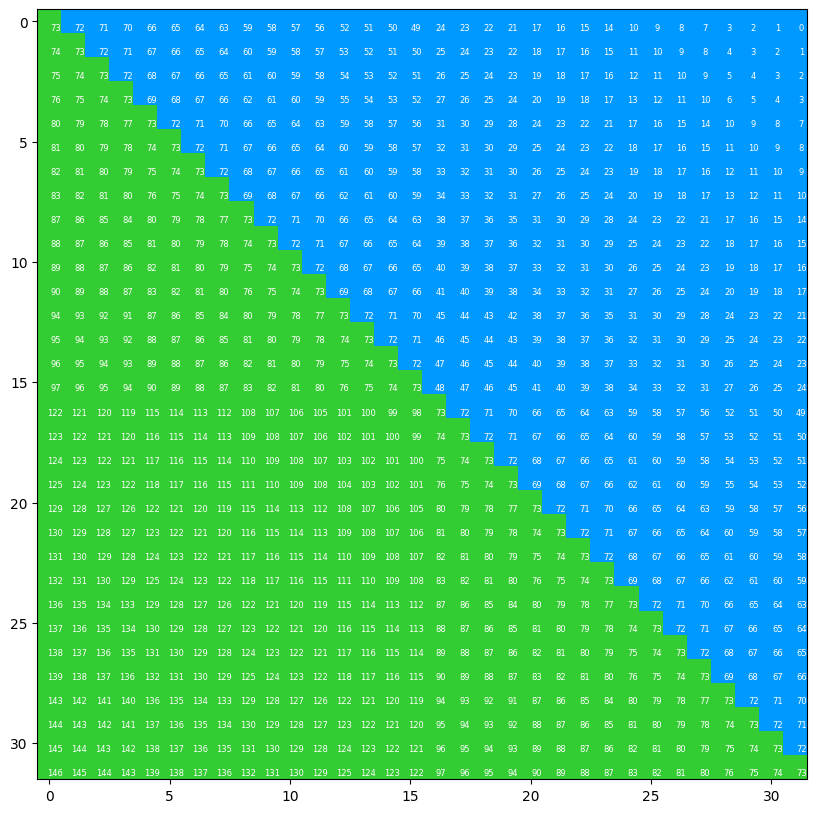

In [ ]:
plt.figure(figsize=(10, 10))
colors_list = ['#0099ff', '#33cc33']
cmap = colors.ListedColormap(colors_list)
mask=mask.numpy()
plt.imshow(mask,cmap=cmap)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        plt.annotate(str(int(mask[i, j])), xy=(j+0.25, i+0.25),
                     ha='center', va='center', color='white', size=6)
  
plt.show()

In [ ]:
#| export 
def create_relative_positional_index_3d(window_size):
    coords_d = torch.arange(window_size[0])
    coords_h = torch.arange(window_size[1])
    coords_w = torch.arange(window_size[2])
    coords = torch.stack(meshgrid([coords_d, coords_h, coords_w], indexing="ij"))
    coords_flatten = torch.flatten(coords, 1)
    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()
    relative_coords[:, :, 0] += window_size[0] - 1
    relative_coords[:, :, 1] += window_size[1] - 1
    relative_coords[:, :, 2] += window_size[2] - 1
    relative_coords[:, :, 0] *= (2 * window_size[1] - 1) * (2 * window_size[2] - 1)
    relative_coords[:, :, 1] *= 2 * window_size[2] - 1
    relative_coords = relative_coords.sum(-1)
    return relative_coords

> Attention

In [ ]:
class Swin3dConfig:
    num_channels = 1
    image_size = (96, 192, 192)
    patch_size = (2, 4, 4)
    embed_dim = 128
    use_absolute_embeddings=True
    hidden_dropout_prob=0.0
    qkv_bias=True
    attention_probs_dropout_prob= True

In [ ]:
#| export 
# Copied from transformers.models.swin.modeling_swin.SwinSelfAttention
class Swin3dSelfAttention(nn.Module):
    def __init__(self, config, dim, num_heads, window_size):
        super().__init__()
        if dim % num_heads != 0:
            raise ValueError(
                f"The hidden size ({dim}) is not a multiple of the number of attention heads ({num_heads})"
            )

        self.num_attention_heads = num_heads
        self.attention_head_size = int(dim / num_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.window_size = (
            window_size if isinstance(window_size, collections.abc.Iterable) else (window_size, window_size, window_size)
        )

        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1) * (2 * self.window_size[2] - 1), num_heads)
        )

        # get pair-wise relative position index for each token inside the window
        
        relative_position_index = create_relative_positional_index_3d(self.window_size)
        self.register_buffer("relative_position_index", relative_position_index)

        self.query = nn.Linear(self.all_head_size, self.all_head_size, bias=config.qkv_bias)
        self.key = nn.Linear(self.all_head_size, self.all_head_size, bias=config.qkv_bias)
        self.value = nn.Linear(self.all_head_size, self.all_head_size, bias=config.qkv_bias)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        batch_size, dim, num_channels = hidden_states.shape
        mixed_query_layer = self.query(hidden_states)

        key_layer = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))
        query_layer = self.transpose_for_scores(mixed_query_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)]
        relative_position_bias = relative_position_bias.view(
            self.window_size[0] * self.window_size[1] * self.window_size[2], 
            self.window_size[0] * self.window_size[1] * self.window_size[2], -1
        )

        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attention_scores = attention_scores + relative_position_bias.unsqueeze(0)

        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in SwinModel forward() function)
            mask_shape = attention_mask.shape[0]
            attention_scores = attention_scores.view(
                batch_size // mask_shape, mask_shape, self.num_attention_heads, dim, dim
            )
            attention_scores = attention_scores + attention_mask.unsqueeze(1).unsqueeze(0)
            attention_scores = attention_scores.view(-1, self.num_attention_heads, dim, dim)

        # Normalize the attention scores to probabilities.
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        return outputs

In [ ]:
ssa = Swin3dSelfAttention(Swin3dConfig(), window_size=(2, 4, 4), dim=128*4, num_heads=4)
ssa

Swin3dSelfAttention(
  (query): Linear(in_features=512, out_features=512, bias=True)
  (key): Linear(in_features=512, out_features=512, bias=True)
  (value): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=True, inplace=False)
)

In [ ]:
hidden_states = torch.randn((3456, 32, 512))
outputs = ssa(hidden_states)
outputs[0].shape

torch.Size([3456, 32, 512])

In [ ]:
#| export 
#Copied from transformers.models.swin.modeling_swin.SwinSelfOutput
class SwinSelfOutput(nn.Module):
    def __init__(self, config, dim):
        super().__init__()
        self.dense = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)

        return hidden_states

In [ ]:
#| export  
# Copied from transformers.models.swin.modeling_swin.SwinAttention
class Swin3dAttention(nn.Module):
    def __init__(self, config, dim, num_heads, window_size):
        super().__init__()
        self.self = Swin3dSelfAttention(config, dim, num_heads, window_size)
        self.output = SwinSelfOutput(config, dim)
        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.self.num_attention_heads, self.self.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.self.query = prune_linear_layer(self.self.query, index)
        self.self.key = prune_linear_layer(self.self.key, index)
        self.self.value = prune_linear_layer(self.self.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.self.num_attention_heads = self.self.num_attention_heads - len(heads)
        self.self.all_head_size = self.self.attention_head_size * self.self.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        self_outputs = self.self(hidden_states, attention_mask, head_mask, output_attentions)
        attention_output = self.output(self_outputs[0], hidden_states)
        outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        return outputs

In [ ]:
#| export 
# Copied from transformers.models.swin.modeling_swin.SwinIntermediate
class SwinIntermediate(nn.Module):
    def __init__(self, config, dim):
        super().__init__()
        self.dense = nn.Linear(dim, int(config.mlp_ratio * dim))
        if isinstance(config.hidden_act, str):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states

In [ ]:
#| export 
# Copied from transformers.models.swin.modeling_swin.SwinOutput
class SwinOutput(nn.Module):
    def __init__(self, config, dim):
        super().__init__()
        self.dense = nn.Linear(int(config.mlp_ratio * dim), dim)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        return hidden_states

## Swin Layer 

First look at what shifted window means in 2D. Lets implement the same in 3D 

In [ ]:
class Swin3dConfig:
    num_channels = 1
    image_size = (96, 192, 192)
    patch_size = (2, 4, 4)
    window_size = (2, 4, 4)
    embed_dim = 128
    use_absolute_embeddings=True
    hidden_dropout_prob=0.0
    qkv_bias=True
    attention_probs_dropout_prob= True
    chunk_size_feed_forward=True
    layer_norm_eps=1e-6
    drop_path_rate=0
    mlp_ratio=4
    hidden_act="gelu"

In [ ]:
input_resolution = (24, 24, 24)
window_size = (2, 4, 4)
min(input_resolution) <= min(window_size)

False

In [ ]:
#| export 
# Copied from transformers.models.swin.modeling_swin.SwinLayer
class Swin3dLayer(nn.Module):
    def __init__(self, config, dim, input_resolution, num_heads, shift_size=0):
        super().__init__()
        self.chunk_size_feed_forward = config.chunk_size_feed_forward
        self.shift_size = shift_size
        self.window_size = config.window_size
        self.input_resolution = input_resolution
        self.layernorm_before = nn.LayerNorm(dim, eps=config.layer_norm_eps)
        self.attention = Swin3dAttention(config, dim, num_heads, window_size=self.window_size)
        self.drop_path = SwinDropPath(config.drop_path_rate) if config.drop_path_rate > 0.0 else nn.Identity()
        self.layernorm_after = nn.LayerNorm(dim, eps=config.layer_norm_eps)
        self.intermediate = SwinIntermediate(config, dim)
        self.output = SwinOutput(config, dim)

    def set_shift_and_window_size(self, input_resolution):
        if input_resolution[0] <= self.window_size[0]:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size[0] = 0
            self.window_size[0] = input_resolution[0]

        if input_resolution[1] <= self.window_size[1]:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size[1] = 0
            self.window_size[1] = input_resolution[1]

        if input_resolution[2] <= self.window_size[2]:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size[2] = 0
            self.window_size[2] = input_resolution[2]

    def get_attn_mask(self, depth, height, width, dtype):
        if (self.shift_size[0] > 0) or (self.shift_size[1] > 0) or (self.shift_size[2] > 0):
            # calculate attention mask for SW-MSA
            img_mask = torch.zeros((1, depth, height, width, 1), dtype=dtype)
            depth_slices = (
                slice(0, -self.window_size[0]),
                slice(-self.window_size[0], -self.shift_size[0]),
                slice(-self.shift_size[0], None),
            )
            height_slices = (
                slice(0, -self.window_size[1]),
                slice(-self.window_size[1], -self.shift_size[1]),
                slice(-self.shift_size[1], None),
            )
            width_slices = (
                slice(0, -self.window_size[2]),
                slice(-self.window_size[2], -self.shift_size[2]),
                slice(-self.shift_size[2], None),
            )
            count = 0
            for d in depth_slices:
                for h in height_slices:
                    for w in width_slices:
                        img_mask[:, d, h, w, :] = count
                        count += 1

            mask_windows = window_partition3d(img_mask, self.window_size)
            mask_windows = mask_windows.view(-1, self.window_size[0] * self.window_size[1] * self.window_size[2])
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None
        return attn_mask

    def maybe_pad(self, hidden_states, depth, height, width):
        pad_right = (self.window_size[2] - width % self.window_size[2]) % self.window_size[2]
        pad_bottom = (self.window_size[1] - height % self.window_size[1]) % self.window_size[1]
        pad_depth = (self.window_size[0] - height % self.window_size[0]) % self.window_size[0]
        pad_values = (0, 0, 0, pad_right, 0, pad_bottom, 0, pad_depth)
        hidden_states = nn.functional.pad(hidden_states, pad_values)
        return hidden_states, pad_values

    def forward(
        self,
        hidden_states: torch.Tensor,
        input_dimensions: Tuple[int, int],
        head_mask: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = False,
        always_partition: Optional[bool] = False,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        if not always_partition:
            self.set_shift_and_window_size(input_dimensions)
        else:
            pass
        depth, height, width = input_dimensions
        batch_size, _, channels = hidden_states.size()
        shortcut = hidden_states

        hidden_states = self.layernorm_before(hidden_states)

        hidden_states = hidden_states.view(batch_size, depth, height, width, channels)

        # pad hidden_states to multiples of window size
        hidden_states, pad_values = self.maybe_pad(hidden_states, depth, height, width)

        _, depth_pad, height_pad, width_pad, _ = hidden_states.shape
        # cyclic shift
        if (self.shift_size[0] > 0) or (self.shift_size[1] > 0) or (self.shift_size[2] > 0):
            shifted_hidden_states = torch.roll(hidden_states, shifts=(-self.shift_size[0], -self.shift_size[1], -self.shift_size[2]), dims=(1, 2, 3))
        else:
            shifted_hidden_states = hidden_states

        # partition windows
        hidden_states_windows = window_partition3d(shifted_hidden_states, self.window_size)
        hidden_states_windows = hidden_states_windows.view(-1, self.window_size[0] * self.window_size[1] * self.window_size[2], channels)
        attn_mask = self.get_attn_mask(depth_pad, height_pad, width_pad, dtype=hidden_states.dtype)
        if attn_mask is not None:
            attn_mask = attn_mask.to(hidden_states_windows.device)

        attention_outputs = self.attention(
            hidden_states_windows, attn_mask, head_mask, output_attentions=output_attentions
        )

        attention_output = attention_outputs[0]

        attention_windows = attention_output.view(-1, self.window_size[0], self.window_size[1], self.window_size[2], channels)
        shifted_windows = window_reverse3d(attention_windows, self.window_size, depth_pad, height_pad, width_pad, )

        # reverse cyclic shift
        if (self.shift_size[0] > 0) or (self.shift_size[1] > 0) or (self.shift_size[2] > 0):
            attention_windows = torch.roll(shifted_windows, shifts=(self.shift_size[0], self.shift_size[1], self.shift_size[2]), dims=(1, 2, 3))
        else:
            attention_windows = shifted_windows

        was_padded = pad_values[3] > 0 or pad_values[5] > 0 or pad_values[7]>0
        if was_padded:
            attention_windows = attention_windows[:, :depth, :height, :width, :].contiguous()

        attention_windows = attention_windows.view(batch_size, height * width * depth, channels)

        hidden_states = shortcut + self.drop_path(attention_windows)

        layer_output = self.layernorm_after(hidden_states)
        layer_output = self.intermediate(layer_output)
        layer_output = hidden_states + self.output(layer_output)

        layer_outputs = (layer_output, attention_outputs[1]) if output_attentions else (layer_output,)
        return layer_outputs


In [ ]:
sl = Swin3dLayer(Swin3dConfig(), dim=128, input_resolution=(24, 24, 24), num_heads=4, shift_size=(2, 2, 2))
sl

Swin3dLayer(
  (layernorm_before): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
  (attention): Swin3dAttention(
    (self): Swin3dSelfAttention(
      (query): Linear(in_features=128, out_features=128, bias=True)
      (key): Linear(in_features=128, out_features=128, bias=True)
      (value): Linear(in_features=128, out_features=128, bias=True)
      (dropout): Dropout(p=True, inplace=False)
    )
    (output): SwinSelfOutput(
      (dense): Linear(in_features=128, out_features=128, bias=True)
      (dropout): Dropout(p=True, inplace=False)
    )
  )
  (drop_path): Identity()
  (layernorm_after): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
  (intermediate): SwinIntermediate(
    (dense): Linear(in_features=128, out_features=512, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): SwinOutput(
    (dense): Linear(in_features=512, out_features=128, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
)

In [ ]:
sl(torch.randn((1, 24*24*24, 128)), (24, 24, 24))[0].shape

torch.Size([1, 13824, 128])

In [ ]:
#| export 
# Copied from transformers.models.swin.modeling_swin.SwinStage
class Swin3dStage(nn.Module):
    def __init__(self, config, dim, input_resolution, depth, num_heads, drop_path, downsample):
        super().__init__()
        self.config = config
        self.dim = dim
        self.blocks = nn.ModuleList(
            [
                Swin3dLayer(
                    config=config,
                    dim=dim,
                    input_resolution=input_resolution,
                    num_heads=num_heads,
                    shift_size=(0 if (i % 2 == 0) else config.window_size[0] // 2, 
                                0 if (i % 2 == 0) else config.window_size[1] // 2, 
                                0 if (i % 2 == 0) else config.window_size[2] // 2),
                )
                for i in range(depth)
            ]
        )

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=nn.LayerNorm)
        else:
            self.downsample = None

        self.pointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        input_dimensions: Tuple[int, int],
        head_mask: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = False,
        always_partition: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        depth, height, width = input_dimensions
        for i, layer_module in enumerate(self.blocks):
            layer_head_mask = head_mask[i] if head_mask is not None else None

            layer_outputs = layer_module(
                hidden_states, input_dimensions, layer_head_mask, output_attentions, always_partition
            )

            hidden_states = layer_outputs[0]

        hidden_states_before_downsampling = hidden_states
        if self.downsample is not None:
            depth_downsampled, height_downsampled, width_downsampled = (depth + 1) // 2, (height + 1) // 2, (width + 1) // 2
            output_dimensions = (depth, height, width, depth_downsampled, height_downsampled, width_downsampled)
            hidden_states = self.downsample(hidden_states_before_downsampling, input_dimensions)
        else:
            output_dimensions = (depth, height, width, depth, height, width)

        stage_outputs = (hidden_states, hidden_states_before_downsampling, output_dimensions)

        if output_attentions:
            stage_outputs += layer_outputs[1:]
        return stage_outputs

In [ ]:
#| export 
class Swin3dConfig(SwinConfig):
    def __init__(self,
        image_size=(92, 192, 192),
        patch_size=(2, 4, 4),
        num_channels=1,
        embed_dim=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=(2, 4, 4),
        mlp_ratio=4.0,
        qkv_bias=True,
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        drop_path_rate=0.1,
        hidden_act="gelu",
        use_absolute_embeddings=False,
        initializer_range=0.02,
        layer_norm_eps=1e-5,
        encoder_stride=32,
        out_features=None,
        out_indices=None,
        **kwargs):
        super().__init__(image_size=image_size,
        patch_size=patch_size,
        num_channels=num_channels,
        embed_dim=embed_dim,
        depths=depths,
        num_heads=num_heads,
        window_size=window_size,
        mlp_ratio=mlp_ratio,
        qkv_bias=qkv_bias,
        hidden_dropout_prob=hidden_dropout_prob,
        attention_probs_dropout_prob=attention_probs_dropout_prob,
        drop_path_rate=drop_path_rate,
        hidden_act=hidden_act,
        use_absolute_embeddings=use_absolute_embeddings,
        initializer_range=initializer_range,
        layer_norm_eps=layer_norm_eps,
        encoder_stride=encoder_stride,
        out_features=out_features,
        out_indices=out_indices,
        **kwargs)
        assert len(image_size) == 3, "we need 3 dimesional image size"
        assert len(patch_size) == 3, "we need 3 dimesional patch size"
        assert len(window_size) == 3, "we need 3 dimesional window size"

In [ ]:
Swin3dConfig()

Swin3dConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": [
    92,
    192,
    192
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "swin",
  "num_channels": 1,
  "num_heads": [
    3,
    6,
    12,
    24
  ],
  "num_layers": 4,
  "out_features": [
    "stage4"
  ],
  "out_indices": [
    4
  ],
  "patch_size": [
    2,
    4,
    4
  ],
  "qkv_bias": true,
  "stage_names": [
    "stem",
    "stage1",
    "stage2",
    "stage3",
    "stage4"
  ],
  "transformers_version": "4.35.0",
  "use_absolute_embeddings": false,
  "window_size": [
    2,
    4,
    4
  ]
}

In [ ]:
#| export 
class Swin3dEncoder(nn.Module):
    def __init__(self, config, grid_size):
        super().__init__()
        self.num_layers = len(config.depths)
        self.config = config
        dpr = [x.item() for x in torch.linspace(0, config.drop_path_rate, sum(config.depths))]
        self.layers = nn.ModuleList(
            [
                Swin3dStage(
                    config=config,
                    dim=int(config.embed_dim * 2**i_layer),
                    input_resolution=(grid_size[0] // (2**i_layer), 
                                      grid_size[1] // (2**i_layer), 
                                      grid_size[2] // (2**i_layer)),
                    depth=config.depths[i_layer],
                    num_heads=config.num_heads[i_layer],
                    drop_path=dpr[sum(config.depths[:i_layer]) : sum(config.depths[: i_layer + 1])],
                    downsample=Swin3dPatchMerging if (i_layer < self.num_layers - 1) else None,
                )
                for i_layer in range(self.num_layers)
            ]
        )

        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        input_dimensions: Tuple[int, int],
        head_mask: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = False,
        output_hidden_states: Optional[bool] = False,
        output_hidden_states_before_downsampling: Optional[bool] = False,
        always_partition: Optional[bool] = False,
        return_dict: Optional[bool] = True,
    ) -> Union[Tuple, SwinEncoderOutput]:
        all_hidden_states = () if output_hidden_states else None
        all_reshaped_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None

        if output_hidden_states:
            batch_size, _, hidden_size = hidden_states.shape
            # rearrange b (d h w) c -> b c d h w
            reshaped_hidden_state = hidden_states.view(batch_size, *input_dimensions, hidden_size)
            reshaped_hidden_state = reshaped_hidden_state.permute(0, 4, 1, 2, 3)
            all_hidden_states += (hidden_states,)
            all_reshaped_hidden_states += (reshaped_hidden_state,)

        for i, layer_module in enumerate(self.layers):
            layer_head_mask = head_mask[i] if head_mask is not None else None

            if self.gradient_checkpointing and self.training:
                layer_outputs = self._gradient_checkpointing_func(
                    layer_module.__call__, hidden_states, input_dimensions, layer_head_mask, output_attentions
                )
            else:
                layer_outputs = layer_module(
                    hidden_states, input_dimensions, layer_head_mask, output_attentions, always_partition
                )

            hidden_states = layer_outputs[0]
            hidden_states_before_downsampling = layer_outputs[1]
            output_dimensions = layer_outputs[2]

            input_dimensions = (output_dimensions[-3], output_dimensions[-2], output_dimensions[-1])

            if output_hidden_states and output_hidden_states_before_downsampling:
                batch_size, _, hidden_size = hidden_states_before_downsampling.shape
                # rearrange b (d h w) c -> b c d h w
                # here we use the original (not downsampled) height and width
                reshaped_hidden_state = hidden_states_before_downsampling.view(
                    batch_size, *(output_dimensions[0], output_dimensions[1], output_dimensions[2]), hidden_size
                )
                reshaped_hidden_state = reshaped_hidden_state.permute(0, 4, 1, 2, 3)
                all_hidden_states += (hidden_states_before_downsampling,)
                all_reshaped_hidden_states += (reshaped_hidden_state,)
            elif output_hidden_states and not output_hidden_states_before_downsampling:
                batch_size, _, hidden_size = hidden_states.shape
                # rearrange b (d h w) c -> b c d h w
                reshaped_hidden_state = hidden_states.view(batch_size, *input_dimensions, hidden_size)
                reshaped_hidden_state = reshaped_hidden_state.permute(0, 4, 1, 2, 3)
                all_hidden_states += (hidden_states,)
                all_reshaped_hidden_states += (reshaped_hidden_state,)

            if output_attentions:
                all_self_attentions += layer_outputs[3:]

        if not return_dict:
            return tuple(v for v in [hidden_states, all_hidden_states, all_self_attentions] if v is not None)

        return SwinEncoderOutput(
            last_hidden_state=hidden_states,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            reshaped_hidden_states=all_reshaped_hidden_states,
        )

In [ ]:
Swin3dEncoder(Swin3dConfig(), grid_size=(48, 48, 48))

Swin3dEncoder(
  (layers): ModuleList(
    (0): Swin3dStage(
      (blocks): ModuleList(
        (0-1): 2 x Swin3dLayer(
          (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attention): Swin3dAttention(
            (self): Swin3dSelfAttention(
              (query): Linear(in_features=96, out_features=96, bias=True)
              (key): Linear(in_features=96, out_features=96, bias=True)
              (value): Linear(in_features=96, out_features=96, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): SwinSelfOutput(
              (dense): Linear(in_features=96, out_features=96, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (drop_path): SwinDropPath(p=0.1)
          (layernorm_after): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (intermediate): SwinIntermediate(
            (dense): Linear(in_features=96, out_features=384, bi

In [ ]:
#| export 
# Copied from transformers.models.swin.modeling_swin.SwinPreTrainedModel
class Swin3dPreTrainedModel(PreTrainedModel):
    """
    An abstract class to handle weights initialization and a simple interface for downloading and loading pretrained
    models.
    """

    config_class = SwinConfig
    base_model_prefix = "swin"
    main_input_name = "pixel_values"
    supports_gradient_checkpointing = True

    def _init_weights(self, module):
        """Initialize the weights"""
        if isinstance(module, (nn.Linear, nn.Conv3d)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

In [ ]:
#| export 
# Copied from transformers.models.swin.modeling_swin.SwinModel
class Swin3dModel(Swin3dPreTrainedModel):
    def __init__(self, config, add_pooling_layer=True, use_mask_token=False):
        super().__init__(config)
        self.config = config
        self.num_layers = len(config.depths)
        self.num_features = int(config.embed_dim * 2 ** (self.num_layers - 1))

        self.embeddings = Swin3dEmbeddings(config, use_mask_token=use_mask_token)
        self.encoder = Swin3dEncoder(config, self.embeddings.patch_grid)

        self.layernorm = nn.LayerNorm(self.num_features, eps=config.layer_norm_eps)
        self.pooler = nn.AdaptiveAvgPool1d(1) if add_pooling_layer else None

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embeddings.patch_embeddings

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        pixel_values: Optional[torch.FloatTensor] = None,
        bool_masked_pos: Optional[torch.BoolTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SwinModelOutput]:
        r"""
        bool_masked_pos (`torch.BoolTensor` of shape `(batch_size, num_patches)`, *optional*):
            Boolean masked positions. Indicates which patches are masked (1) and which aren't (0).
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if pixel_values is None:
            raise ValueError("You have to specify pixel_values")

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length x seq_length]
        head_mask = self.get_head_mask(head_mask, len(self.config.depths))

        embedding_output, input_dimensions = self.embeddings(pixel_values, bool_masked_pos=bool_masked_pos)

        encoder_outputs = self.encoder(
            embedding_output,
            input_dimensions,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states, 
            return_dict=return_dict,
        )

        sequence_output = encoder_outputs[0]
        sequence_output = self.layernorm(sequence_output)

        pooled_output = None
        if self.pooler is not None:
            pooled_output = self.pooler(sequence_output.transpose(1, 2))
            pooled_output = torch.flatten(pooled_output, 1)

        if not return_dict:
            output = (sequence_output, pooled_output) + encoder_outputs[1:]

            return output

        return SwinModelOutput(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
            reshaped_hidden_states=encoder_outputs.reshaped_hidden_states,
        )

In [ ]:
Swin3dConfig()

Swin3dConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": [
    92,
    192,
    192
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "swin",
  "num_channels": 1,
  "num_heads": [
    3,
    6,
    12,
    24
  ],
  "num_layers": 4,
  "out_features": [
    "stage4"
  ],
  "out_indices": [
    4
  ],
  "patch_size": [
    2,
    4,
    4
  ],
  "qkv_bias": true,
  "stage_names": [
    "stem",
    "stage1",
    "stage2",
    "stage3",
    "stage4"
  ],
  "transformers_version": "4.35.0",
  "use_absolute_embeddings": false,
  "window_size": [
    2,
    4,
    4
  ]
}

In [ ]:
s3m = Swin3dModel(Swin3dConfig(), False, False)
s3m

Swin3dModel(
  (embeddings): Swin3dEmbeddings(
    (patch_embeddings): Swin3dPatchEmbeddings(
      (projection): Conv3d(1, 96, kernel_size=(2, 4, 4), stride=(2, 4, 4))
    )
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Swin3dEncoder(
    (layers): ModuleList(
      (0): Swin3dStage(
        (blocks): ModuleList(
          (0-1): 2 x Swin3dLayer(
            (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attention): Swin3dAttention(
              (self): Swin3dSelfAttention(
                (query): Linear(in_features=96, out_features=96, bias=True)
                (key): Linear(in_features=96, out_features=96, bias=True)
                (value): Linear(in_features=96, out_features=96, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): SwinSelfOutput(
                (dense): Linear(in_features=96, out_features

In [ ]:
s3m.encoder.layers[-2]

Swin3dStage(
  (blocks): ModuleList(
    (0-5): 6 x Swin3dLayer(
      (layernorm_before): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (attention): Swin3dAttention(
        (self): Swin3dSelfAttention(
          (query): Linear(in_features=384, out_features=384, bias=True)
          (key): Linear(in_features=384, out_features=384, bias=True)
          (value): Linear(in_features=384, out_features=384, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (output): SwinSelfOutput(
          (dense): Linear(in_features=384, out_features=384, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (drop_path): SwinDropPath(p=0.1)
      (layernorm_after): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (intermediate): SwinIntermediate(
        (dense): Linear(in_features=384, out_features=1536, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): SwinOutput(
        (dense): Li

In [ ]:
s3m.encoder.layers[-1]

Swin3dStage(
  (blocks): ModuleList(
    (0-1): 2 x Swin3dLayer(
      (layernorm_before): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attention): Swin3dAttention(
        (self): Swin3dSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (output): SwinSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (drop_path): SwinDropPath(p=0.1)
      (layernorm_after): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (intermediate): SwinIntermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): SwinOutput(
        (dense): Li

In [ ]:
x = torch.randn((1, 1, 96, 192, 192))
out = s3m(x, output_hidden_states=True)

In [ ]:
[i.shape for i in out.hidden_states]

[torch.Size([1, 110592, 96]),
 torch.Size([1, 13824, 192]),
 torch.Size([1, 1728, 384]),
 torch.Size([1, 216, 768]),
 torch.Size([1, 216, 768])]

The following modifications are done. 
- we have to output the `hidden_states_before downsampling` as per the paper but here `hidden_state` True will give ouputs of `hidden_state_after_downsampling` . so we made changes accordingly
- Swin3D basically works with only 3D images

The following is what is defined in the paper
• Swin-T: C = 96, layer numbers = {2, 2, 6, 2}
• Swin-S: C = 96, layer numbers ={2, 2, 18, 2}
• Swin-B: C = 128, layer numbers ={2, 2, 18, 2} 
• Swin-L: C = 192, layer numbers ={2, 2, 18, 2}

In [ ]:
swint = Swin3dModel(Swin3dConfig(embed_dim=96, depths=(2, 2, 6, 2)), False, False)
count = 0
for name, params in swint.named_parameters():
    count += params.numel()
count #29,068,446

29068446

> 29 million parameters will be an overkill may be. we will see how to keep it to only 2 layers. 

In [ ]:
swint = Swin3dModel(Swin3dConfig(embed_dim=96, depths=(2, 6), num_heads=[3, 6], stage_names=["stem", "stage1", "stage2"]), False, False)
count = 0
for name, params in swint.named_parameters():
    count += params.numel()
count #3051774 this came down to 3 million

3051774

In [ ]:
x = torch.randn((1, 1, 96, 192, 192))
out = swint(x, output_hidden_states=True)
[i.shape for i in out.hidden_states]

[torch.Size([1, 110592, 96]),
 torch.Size([1, 13824, 192]),
 torch.Size([1, 13824, 192])]

The following is what we need to test for 3D 

• Swin-T: C = 96, layer numbers = {2, 6}  
• Swin-S: C = 96, layer numbers ={2, 18}  
• Swin-B: C = 128, layer numbers ={2, 18}   
• Swin-L: C = 192, layer numbers ={2, 18}  

> we will primarily use this repo for backbones and so lets define a backbone here. 

In [ ]:
#| export 
# Copied from transformers.models.swin.modeling_swin.Swin3dBackbone
class Swin3dBackbone(Swin3dPreTrainedModel, BackboneMixin):
    def __init__(self, config: Swin3dConfig):
        super().__init__(config)
        super()._init_backbone(config)

        self.num_features = [config.embed_dim] + [int(config.embed_dim * 2**i) for i in range(len(config.depths))]
        self.embeddings = Swin3dEmbeddings(config)
        self.encoder = Swin3dEncoder(config, self.embeddings.patch_grid)

        # Add layer norms to hidden states of out_features
        hidden_states_norms = {}
        for stage, num_channels in zip(self._out_features, self.channels):
            hidden_states_norms[stage] = nn.LayerNorm(num_channels)
        self.hidden_states_norms = nn.ModuleDict(hidden_states_norms)

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embeddings.patch_embeddings

    def forward(
        self,
        pixel_values: torch.Tensor,
        output_hidden_states: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> BackboneOutput:
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions

        embedding_output, input_dimensions = self.embeddings(pixel_values)

        outputs = self.encoder(
            embedding_output,
            input_dimensions,
            head_mask=None,
            output_attentions=output_attentions,
            output_hidden_states=True,
            output_hidden_states_before_downsampling=True,
            always_partition=True,
            return_dict=True,
        )

        hidden_states = outputs.reshaped_hidden_states

        feature_maps = ()
        for stage, hidden_state in zip(self.stage_names, hidden_states):
            if stage in self.out_features:
                batch_size, num_channels, depth, height, width = hidden_state.shape
                hidden_state = hidden_state.permute(0, 2, 3, 4, 1).contiguous()
                hidden_state = hidden_state.view(batch_size, height * width * depth, num_channels)
                hidden_state = self.hidden_states_norms[stage](hidden_state)
                hidden_state = hidden_state.view(batch_size, depth, height, width, num_channels)
                hidden_state = hidden_state.permute(0, 4, 1, 2, 3).contiguous()
                feature_maps += (hidden_state,)

        if not return_dict:
            output = (feature_maps,)
            if output_hidden_states:
                output += (outputs.hidden_states,)
            return output

        return BackboneOutput(
            feature_maps=feature_maps,
            hidden_states=outputs.hidden_states if output_hidden_states else None,
            attentions=outputs.attentions,
        )

In [ ]:
config = Swin3dConfig(embed_dim=96, depths=(2, 4), out_features=["stage1", "stage2"])
model = Swin3dBackbone(config)

In [ ]:
out = model(torch.randn((1, 1, 96, 192, 192)), output_hidden_states=True)

In [ ]:
[i.shape for i in out.feature_maps]

[torch.Size([1, 96, 48, 48, 48]), torch.Size([1, 192, 24, 24, 24])]

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()